In [4]:
from openbb_terminal.stocks.options import (
    alphaquery_view,
    barchart_view,
    calculator_view,
    chartexchange_view,
    fdscanner_view,
    intrinio_model,
    intrinio_view,
    nasdaq_model,
    tradier_model,
    tradier_view,
    yfinance_model,
    yfinance_view,
)
import pytz
import pandas as pd
from openbb_terminal import OpenBBFigure, theme
import matplotlib.pyplot as plt
from openbb_terminal.helper_funcs import get_user_timezone
from openbb_terminal.stocks.options import alphaquery_model
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
from openbb_terminal.stocks.options.yfinance_model import (
    generate_data,
    get_option_chain,
    get_price,
)
from pathlib import Path
from openbb_terminal.stocks import cboe_view, stocks_helper, stocks_view
from openbb_terminal.stocks.options import op_helpers, yfinance_model
from typing import Any, Dict, List, Optional, Union
from openbb_terminal.core.plots.plotly_ta.ta_class import PlotlyTA
from openbb_terminal.reports import widget_helpers as widgets
from collections import defaultdict
from matplotlib import pyplot as plt
import yfinance as yf
import numpy as np
from scipy.stats import norm
import talib
from tabulate import tabulate
import base64
from google.cloud import storage
import os



In [33]:
symbol = "SPY"
full_chain = yfinance_model.get_full_option_chain(symbol)
full_chain['strike'] = full_chain['strike'].astype(float)
current_price = yfinance_model.get_price(symbol) 

Output()

In [73]:
min_strike = 0.90 * current_price
max_strike = 1.10 * current_price
div_cont: float = 0
rf: Optional[float] = None
show_all: bool = False

In [74]:
one_chain = full_chain[full_chain["expiration"] == '2023-10-24']
from collections import defaultdict 
total_gex = defaultdict(list)

In [75]:
for expiry, chain in one_chain.groupby(["expiration"]):
    chain = chain[chain["strike"] >= min_strike]
    chain = chain[chain["strike"] <= max_strike]
    calls = op_helpers.get_greeks(
        current_price=current_price,
        expire=expiry,
        calls=chain[chain["optionType"] == "call"],
        puts=chain[chain["optionType"] == "put"],
        div_cont=div_cont,
        rf=rf,
        opt_type=1,
        show_extra_greeks=False,
    )

    chain = chain[chain["optionType"] == "call"]
    for index, row in calls.iterrows():
        oi = chain[chain["strike"] == row.Strike]
        total_gex['Strike'].append(row.Strike)
        total_gex['CALL'].append(oi['openInterest'].iloc[0] * row.Gamma)


In [76]:
for expiry, chain in one_chain.groupby(["expiration"]):
    chain = chain[chain["strike"] >= min_strike]
    chain = chain[chain["strike"] <= max_strike]
    calls = op_helpers.get_greeks(
        current_price=current_price,
        expire=expiry,
        calls=chain[chain["optionType"] == "call"],
        puts=chain[chain["optionType"] == "put"],
        div_cont=div_cont,
        rf=rf,
        opt_type=-1,
        show_extra_greeks=False,
    )

    chain = chain[chain["optionType"] == "put"]
    for index, row in calls.iterrows():
        oi = chain[chain["strike"] == row.Strike]
        total_gex['PUT'].append(-(oi['openInterest'].iloc[0] * row.Gamma))

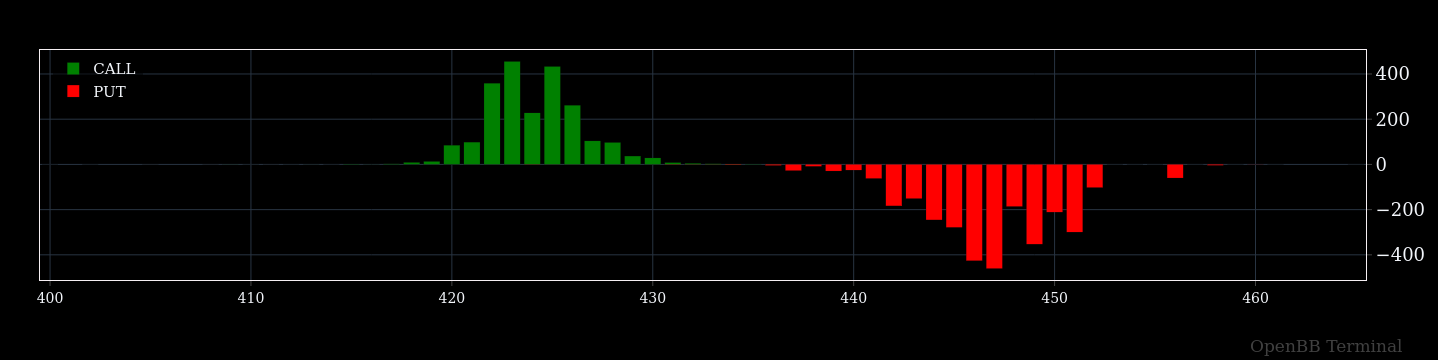

In [77]:
option_absolute_plot = OpenBBFigure()
option_absolute_plot.add_bar(
    x=total_gex['Strike'],
    y=total_gex['CALL'],
    name='CALL',
    marker_color="green",
    width=0.8
)

option_absolute_plot.add_bar(
    x=total_gex['Strike'],
    y=total_gex['PUT'],
    name='PUT',
    marker_color="red",
    width=0.8
)
option_absolute_plot.show()